In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

sns.set_theme("paper")
sns.set_style("whitegrid")

In [2]:
import os

DATA_DIR = "/home/ubuntu/data"

corona_ann = sc.read_h5ad(os.path.join(DATA_DIR, "COVAC_corrected_annotated.h5ad"))

In [3]:
# manually build ordinal annotation
corona_ann.obs["ordinal_label"] = corona_ann.obs.timepoint.replace({"t1": 0, "t2": 1, "t3": 2, "t4": 3,
                                                                        "d1": 0, "d28": 1, "d56": 2, "M6": 3}).astype("int8")

corona_ann.obs.ordinal_label

new_index
AAACCCACAAGCCCAC-59    2
AAACCCATCTTGTTAC-59    2
AAACGAAAGACAACTA-59    2
AAACGAACATGGGTTT-59    2
AAACGCTTCACTCGAA-59    2
                      ..
TTTGTTGTCGGCCTTT-42    1
TTTGTTGTCGGTAGAG-42    1
TTTGTTGTCGTGGACC-42    1
TTTGTTGTCTATCGGA-42    1
TTTGTTGTCTGTTGGA-42    1
Name: ordinal_label, Length: 398598, dtype: int8

## Subset by cohorts

In [4]:
corona_b = corona_ann[corona_ann.obs.cohort == "B"].copy()

In [5]:
corona_p = corona_ann[corona_ann.obs.cohort == "P"].copy()

In [30]:
cd4 = ["naive CD4+ T", "CD4+ Treg", "CD4+ T"]
cd8 = ["CD8+ T", "naive CD8+ T"]
t_cells = cd4 + cd8
b_cells = ["B", "Plasma"]

## Run on Cohort P

### Run on all

In [43]:
from pypsupertime import Psupertime

# Psupertime parameters
regularization_params = {"scoring": "accuracy", "n_jobs": 5, "reg_low": 0.001, "reg_high": 0.25, "n_params": 30}
estimator_params = {"penalty": "l1", "early_stopping": False, "min_iter": 75, "n_iter_no_change": 20, "max_iter": 500}
preprocessing_params = {"select_genes": "hvg", "log": False, "normalize": False, "scale": True, "smooth": False}

psuper_p_all = Psupertime(n_batches=10,
               regularization_params=regularization_params, 
               estimator_params=estimator_params,
               preprocessing_params=preprocessing_params)
cohort_p_all = psuper_p_all.run(corona_p[corona_p.obs.cell_type.isin(t_cells + b_cells)].copy(), "ordinal_label")

Input Data: n_genes=18910, n_cells=167388
Preprocessing: done. mode='hvg', n_genes=2249, n_cells=167388
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.481868.02, n_genes=187
Total elapsed time:  10:55:31.115727


Best idx: 24 Best Score: 0.48140255608251364 Best Lambda: 0.002590824125627554 Scores std: 0.04506159274342137
1SE idx: 19 1SE Score: 0.44564101147734486 1SE Lambda: 0.006712369649933781


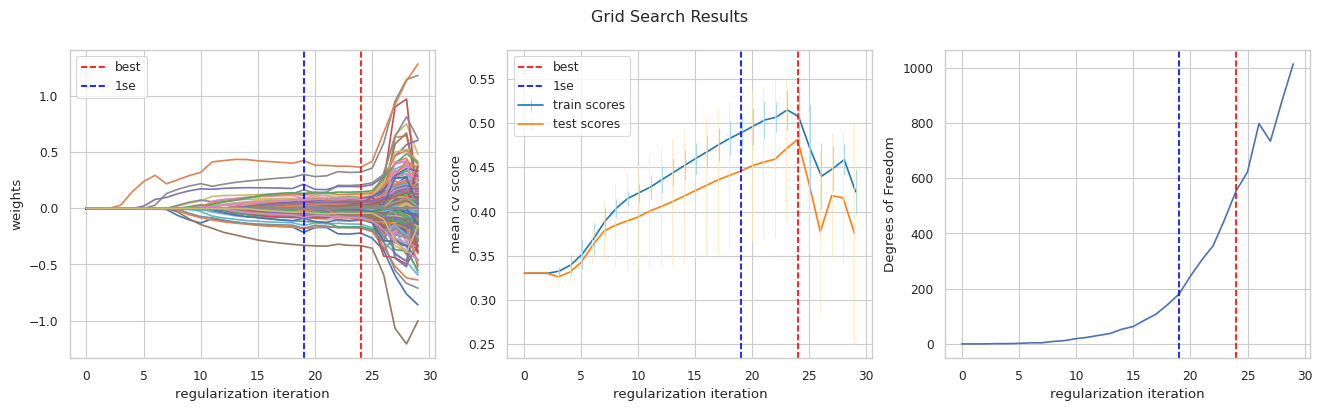

In [44]:
f = psuper_p_all.plot_grid_search()
f.savefig("cohort_p_allcells_gridsearch.png")

Model Degrees of freedom 187
Accuracy: 0.4818684732477836
Balanced accuracy: 0.46376390906664233
Mean absolute delta: 0.6339131011330862


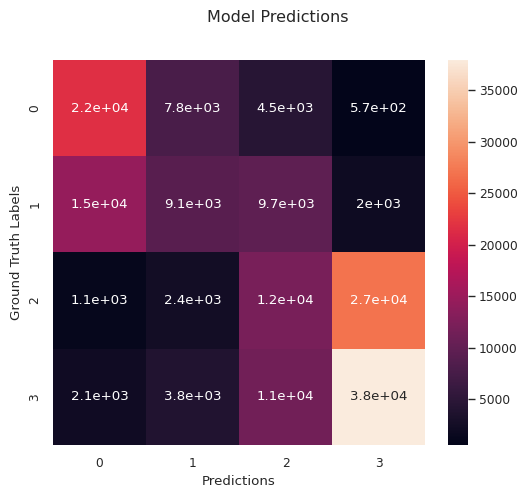

In [62]:
f = psuper_p_all.plot_model_perf(train=(cohort_p_all.X, cohort_p_all.obs.ordinal_label), figsize=(6,5))
f.savefig("cohort_p_allcells_predictions_v2.png")

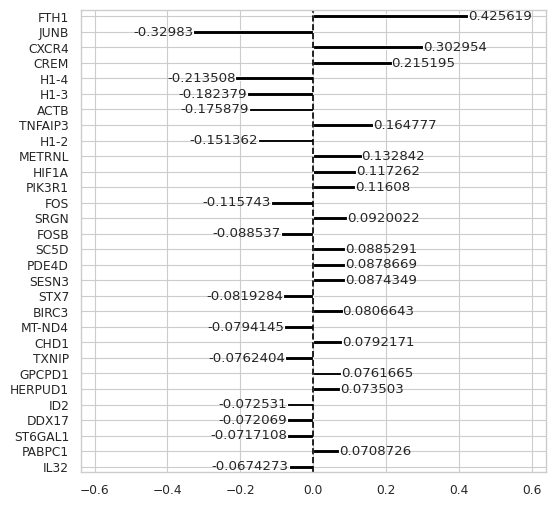

In [63]:
fig = psuper_p_all.plot_identified_gene_coefficients(cohort_p_all)
f.savefig("cohort_p_allcells_coefficients_v2.png")

### Run on CD4+ T-cells

In [35]:
# Psupertime parameters
regularization_params = {"scoring": "accuracy", "n_jobs": 5, "reg_low": 0.001, "reg_high": 0.25, "n_params": 30}
estimator_params = {"penalty": "l1", "early_stopping": False, "min_iter": 75, "max_iter": 500, "n_iter_no_change": 20}
preprocessing_params = {"select_genes": "all", "log": False, "normalize": False, "scale": True, "smooth": False}

In [36]:
from pypsupertime import Psupertime
psuper_p_cd4 = Psupertime(n_batches=10,
               regularization_params=regularization_params, 
               estimator_params=estimator_params,
               preprocessing_params=preprocessing_params)
cohort_p_cd4 = psuper_p_cd4.run(corona_p[corona_p.obs.cell_type.isin(cd4)].copy(), "ordinal_label")

Input Data: n_genes=18910, n_cells=101113
Preprocessing: done. mode='hvg', n_genes=2811, n_cells=101113
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.472926.02, n_genes=69
Total elapsed time:  5:27:29.080309


Best idx: 21 Best Score: 0.4811545907577157 Best Lambda: 0.004586703766880212 Scores std: 0.049716151398111044
1SE idx: 15 1SE Score: 0.4353345940953405 1SE Lambda: 0.014375607647191861


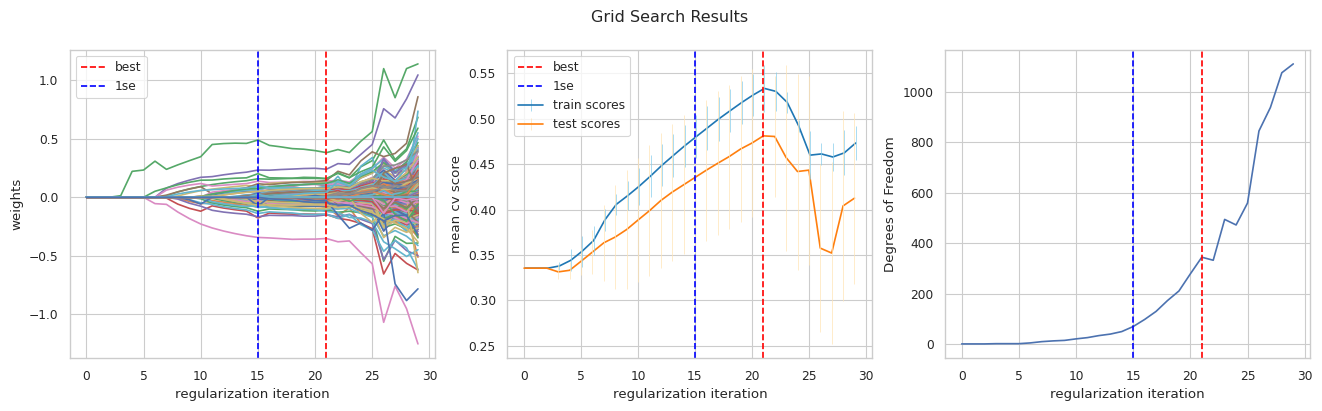

In [38]:
fig = psuper_p_cd4.plot_grid_search()

Model Degrees of freedom 69
Accuracy: 0.4729263299476823
Balanced accuracy: 0.45242241037335934
Mean absolute delta: 0.6639461099506595


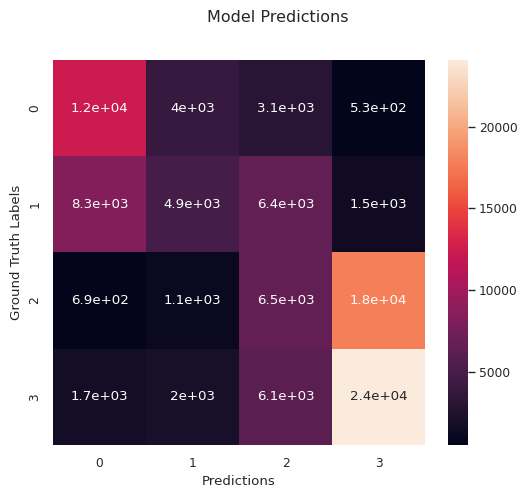

In [39]:
fig = psuper_p_cd4.plot_model_perf(train=(cohort_p_cd4.X, cohort_p_cd4.obs.ordinal_label), figsize=(6,5))

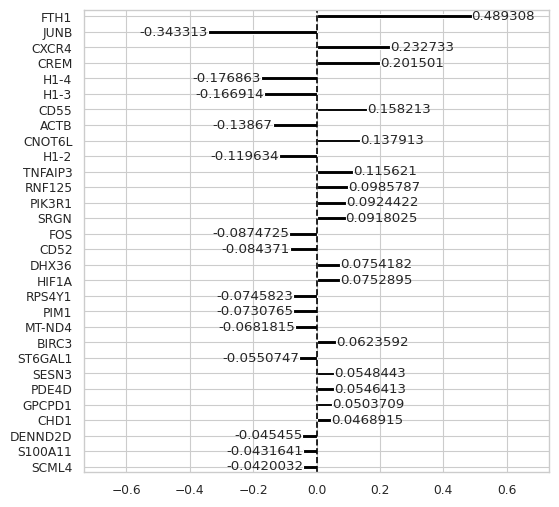

In [128]:
fig = psuper_p_cd4.plot_identified_gene_coefficients(cohort_p_cd4)

In [130]:
"LAMPA" in cohort_p_cd4.var.psupertime_weight.abs().sort_values(ascending=False)[:68].index

False

In [118]:
cohort_p_cd4.var.psupertime_weight.abs().sort_values(ascending=False)[:68].index

Index(['FTH1', 'JUNB', 'CXCR4', 'CREM', 'H1-4', 'H1-3', 'CD55', 'ACTB',
       'CNOT6L', 'H1-2', 'TNFAIP3', 'RNF125', 'PIK3R1', 'SRGN', 'FOS', 'CD52',
       'DHX36', 'HIF1A', 'RPS4Y1', 'PIM1', 'MT-ND4', 'BIRC3', 'ST6GAL1',
       'SESN3', 'PDE4D', 'GPCPD1', 'CHD1', 'DENND2D', 'S100A11', 'SCML4',
       'IL6R', 'LRRN3', 'DDX17', 'FOSB', 'SC5D', 'CD69', 'IPCEF1', 'TXNIP',
       'SPN', 'PABPC1', 'IL32', 'TSC22D3', 'ID2', 'SLC43A2', 'AKAP13',
       'METRNL', 'LPAR6', 'FOSL2', 'SEC14L2', 'RGCC', 'ZNF441', 'ZFP36L2',
       'DDIT4', 'CASP8AP2', 'TRABD2A', 'REL', 'ATM', 'EZR', 'MACF1', 'TRIM73',
       'IGHA1', 'HLA-DRA', 'SH2D3C', 'SERINC5', 'EPB41', 'NFKBIA', 'ZNF682',
       'ATP8B2'],
      dtype='object')

### Run on CD4+ T-cells with elastic

In [131]:
# Psupertime parameters
regularization_params = {"scoring": "accuracy", "n_jobs": 5, "reg_low": 0.001, "reg_high": 0.25, "n_params": 30}
estimator_params = {"penalty": "elasticnet", "l1_ratio": 0.75, "early_stopping": False, "min_iter": 75, "max_iter": 500, "n_iter_no_change": 20}
preprocessing_params = {"select_genes": "hvg", "log": False, "normalize": False, "scale": True, "smooth": False}

from pypsupertime import Psupertime
psuper_p_cd4_en = Psupertime(n_batches=10,
               regularization_params=regularization_params, 
               estimator_params=estimator_params,
               preprocessing_params=preprocessing_params)
cohort_p_cd4_en = psuper_p_cd4_en.run(corona_p[corona_p.obs.cell_type.isin(cd4)].copy(), "ordinal_label")

Input Data: n_genes=18910, n_cells=101113
Preprocessing: done. mode='hvg', n_genes=2811, n_cells=101113
Grid Search CV: CPUs=5, n_folds=5


KeyboardInterrupt: 

### Run on T-cells

In [50]:
from pypsupertime import Psupertime

# Psupertime parameters
regularization_params = {"scoring": "accuracy", "n_jobs": 5, "reg_low": 0.001, "reg_high": 0.25, "n_params": 30}
estimator_params = {"penalty": "l1", "early_stopping": False, "max_iter": 75, "n_iter_no_change": 20}
preprocessing_params = {"select_genes": "hvg", "log": False, "normalize": False, "scale": True, "smooth": False}

psuper_p_tcells = Psupertime(n_batches=10,
               regularization_params=regularization_params, 
               estimator_params=estimator_params,
               preprocessing_params=preprocessing_params)
cohort_p_tcells = psuper_p_tcells.run(corona_p[corona_p.obs.cell_type.isin(t_cells)].copy(), "ordinal_label")

Input Data: n_genes=18910, n_cells=147535
Preprocessing: done. mode='hvg', n_genes=2671, n_cells=147535
Grid Search CV: CPUs=5, n_folds=5
Regularization: done   
Refit on all data: done. accuracy=0.484048.02, n_genes=123
Total elapsed time:  3:21:13.386013


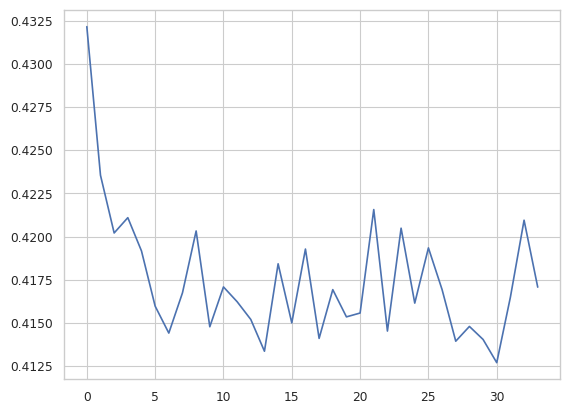

In [51]:
from matplotlib import pyplot as plt
plt.plot(psuper_p_tcells.model.train_losses_)

Best idx: 27 Best Score: 0.47633442911851426 Best Lambda: 0.0014634408479576623 Scores std: 0.046075019256171905
1SE idx: 17 1SE Score: 0.44107499915274345 1SE Lambda: 0.00982315593230438


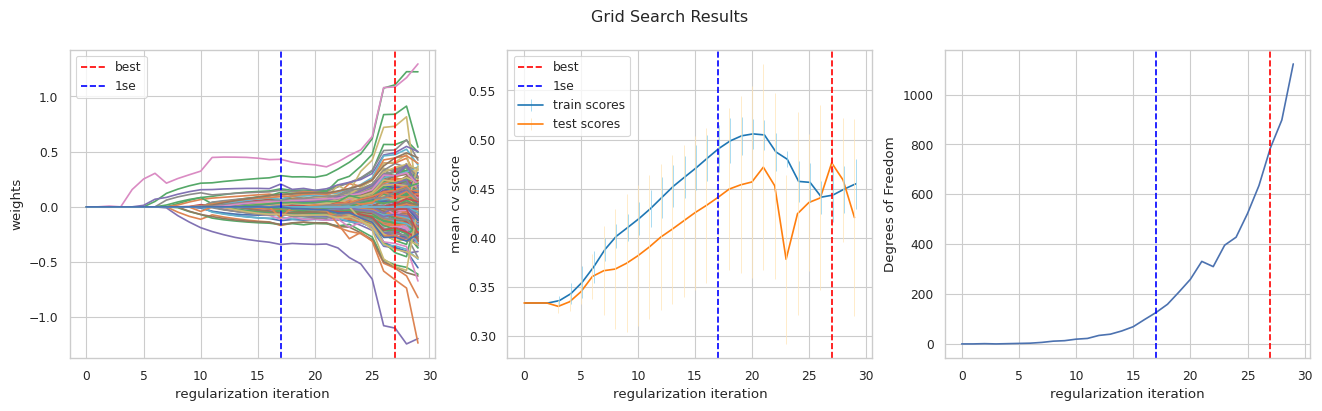

In [52]:
f = psuper_p_tcells.plot_grid_search()
f.savefig("cohort_p_tcells_gridsearch_v1.png")

In [53]:
#psuper_p_tcells.refit_and_predict(cohort_p_tcells, "index", 14)

Model Degrees of freedom 123
Accuracy: 0.4840478530518182
Balanced accuracy: 0.465882895572051
Mean absolute delta: 0.6331019536050296


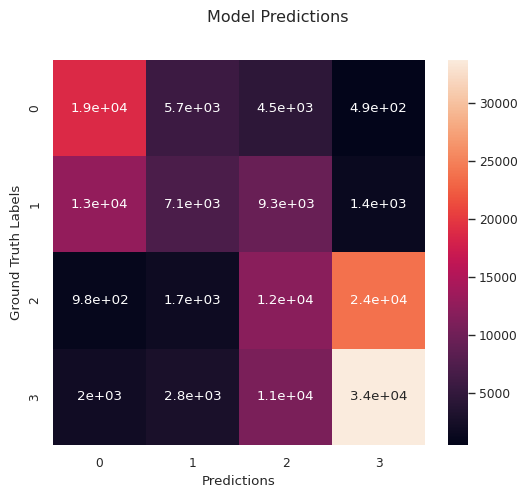

In [54]:
f = psuper_p_tcells.plot_model_perf(train=(cohort_p_tcells.X, cohort_p_tcells.obs.ordinal_label), figsize=(6,5))
f.savefig("cohort_p_tcells_predictions_v2.png")

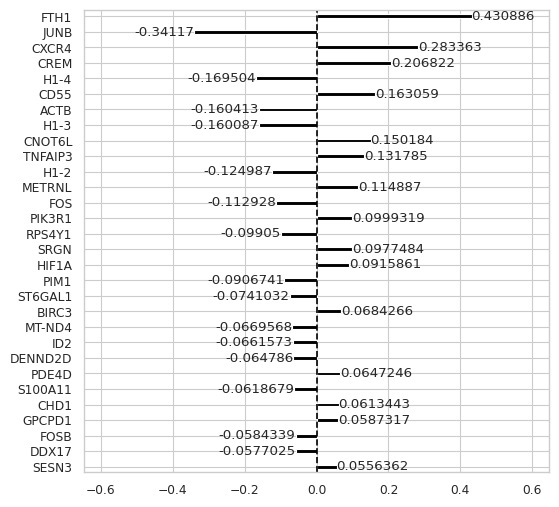

In [55]:
f = psuper_p_tcells.plot_identified_gene_coefficients(cohort_p_tcells)
f.savefig("cohort_p_tcells_genes_v2.png")

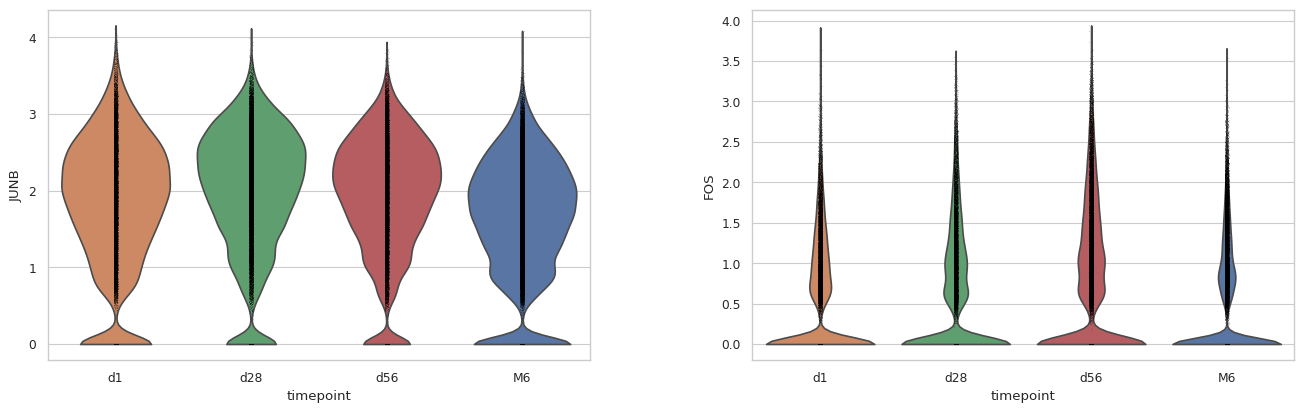

In [136]:
# Top 4 Genes FTH1, CXCR4, 
fig = sc.pl.violin(corona_p[corona_p.obs.cell_type.isin(t_cells)],
             keys=["JUNB", "FOS"],
             groupby="timepoint",
             order=["d1", "d28", "d56", "M6"],
             jitter=0.015, size=0.25,
             log=False,
             save="CP_More.png")


In [56]:
#genes = cohort_p_tcells.var.psupertime_weight.abs().sort_values(ascending=False)
#genes.to_csv("cohort_p_tcells_sparsemodel_genes.csv", sep=",")

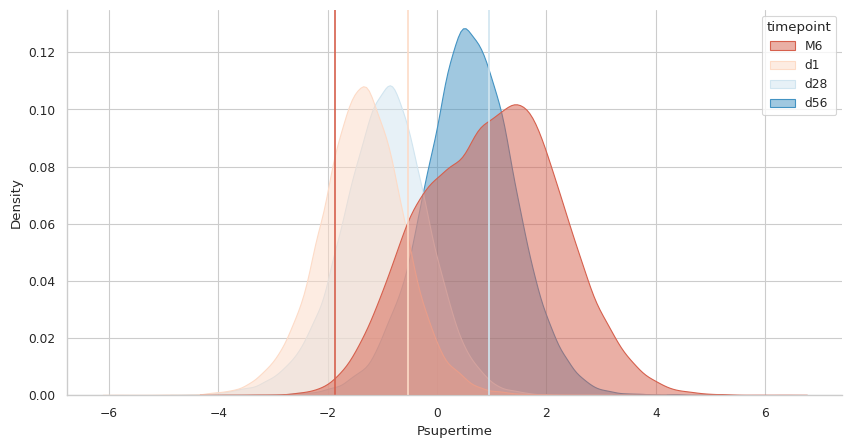

In [57]:
fig = psuper_p_tcells.plot_labels_over_psupertime(cohort_p_tcells, "timepoint")
fig.savefig("cohort_p_tcells_labels_over_psupertime_v2.png")

### Run on B/Plasma Cells

In [58]:
from pypsupertime import Psupertime

regularization_params = {"scoring": "accuracy", "n_jobs": 5, "reg_low": 0.0005, "reg_high": 0.25, "n_params": 30}
estimator_params = {"penalty": "l1", "early_stopping": False, "min_iter": 75, "max_iter": 500, "n_iter_no_change": 20}
preprocessing_params = {"select_genes": "hvg", "log": False, "normalize": False, "scale": True, "smooth": False}

psuper_p_bcells = Psupertime(n_batches=100,
               regularization_params=regularization_params, 
               estimator_params=estimator_params,
               preprocessing_params=preprocessing_params)
cohort_p_bcells = psuper_p_bcells.run(corona_p[corona_p.obs.cell_type.isin(b_cells)].copy(), "ordinal_label")

Input Data: n_genes=18910, n_cells=19853
Preprocessing: done. mode='hvg', n_genes=2699, n_cells=19853
Grid Search CV: CPUs=5, n_folds=5


/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/lib/python3.8/site-packages/pypsupertime/model.py:349: RuntimeWarning: overflow encountered in exp
  exp = np.exp(temp)
/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/lib/python3.8/site-packages/pypsupertime/model.py:350: RuntimeWarning: invalid value encountered in divide
  logit[:, i] = exp / (1 + exp)


Regularization: done   
Refit on all data: done. accuracy=0.465522.02, n_genes=23
Total elapsed time:  0:53:10.520135


Best idx: 24 Best Score: 0.4853137260250164 Best Lambda: 0.0014598547936068079 Scores std: 0.06001713984056901
1SE idx: 9 1SE Score: 0.44219556520288456 1SE Lambda: 0.036335289771798215


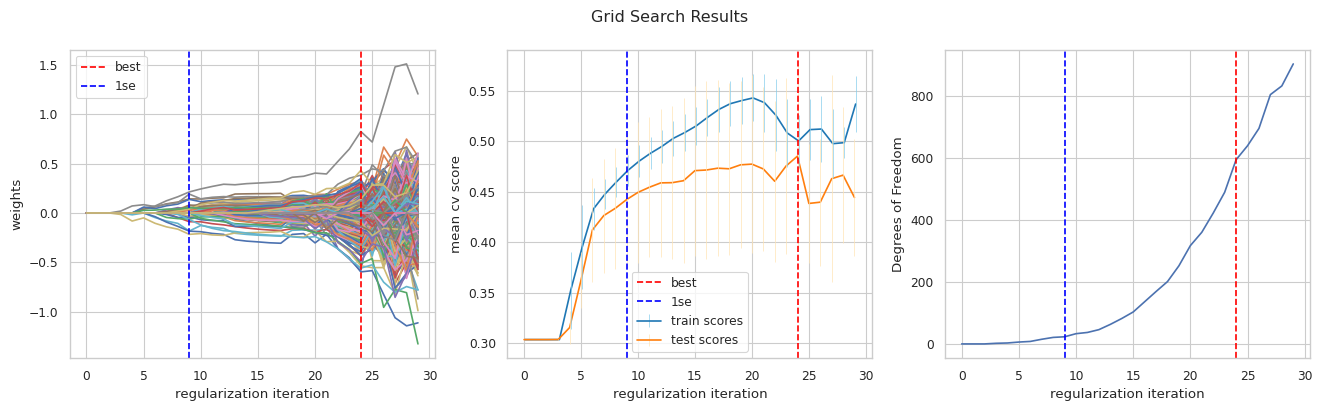

In [59]:
f = psuper_p_bcells.plot_grid_search()
f.savefig("cohort_p_bcells_gridsearch_v2.png")

Model Degrees of freedom 23
Accuracy: 0.46552158363975216
Balanced accuracy: 0.4191539998967222
Mean absolute delta: 0.8450704867571348


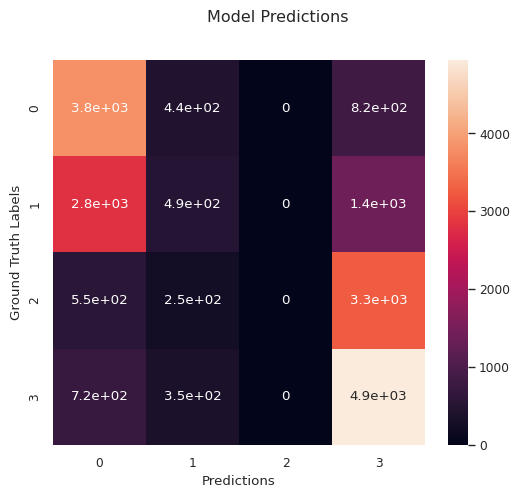

In [60]:
f = psuper_p_bcells.plot_model_perf(train=(cohort_p_bcells.X, cohort_p_bcells.obs.ordinal_label), figsize=(6,5))
f.savefig("cohort_p_bcells_predictions_v2.png")

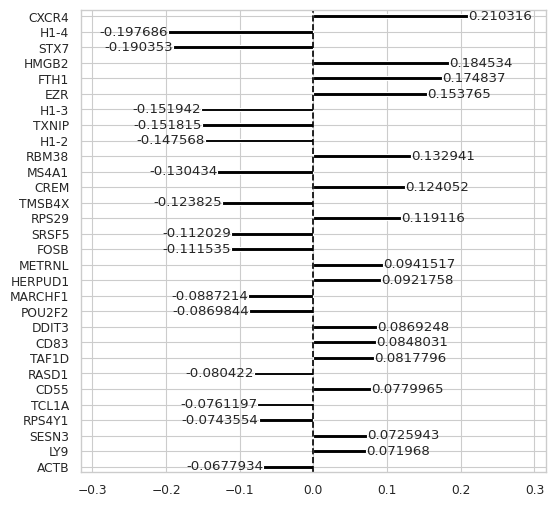

In [42]:
f = psuper_p_bcells.plot_identified_gene_coefficients(cohort_p_bcells)
f.savefig("cohort_p_bcells_genes_v2.png")

/home/ubuntu/.local/share/virtualenvs/masterthesis-aGTe3VWb/lib/python3.8/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


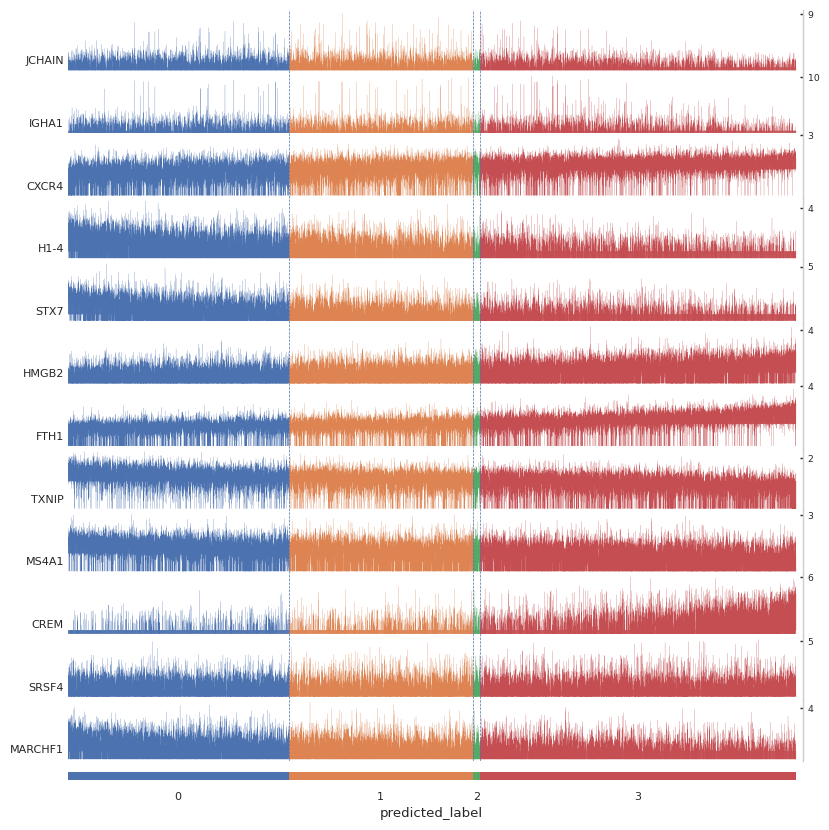

In [14]:
cohort_p_bcells.obs.predicted_label = cohort_p_bcells.obs.predicted_label.astype("category")

sc.pl.tracksplot(cohort_p_bcells[cohort_p_bcells.obs.psupertime.sort_values().index], 
                 var_names=["JCHAIN", "IGHA1", "CXCR4","H1-4", "STX7", "HMGB2", "FTH1", "TXNIP", "MS4A1", "CREM", "SRSF4", "MARCHF1"],
                 groupby="predicted_label",
                 categories_order=["d1", "d28", "d56", "M6"],
                 figsize=(10,10)
                )

In [15]:
import seaborn as sns

df = pd.DataFrame.from_dict({"psupertime": cohort_p_bcells.obs.psupertime,
                             "expression": cohort_p_bcells[:, cohort_p_bcells.var_names == "MS4A1"].X.flatten()})

df.sort_values("psupertime")
#sns.lineplot(df.sort_values("psupertime"), x="psupertime", y="expression")

,psupertime,expression
new_index,,
CTCCAACGTCGGTACC-29,-4.363403,0.592653
ATTGTTCGTTGCACGC-29,-4.241561,0.554511
TTACCGCGTTGCGGAA-29,-4.201379,0.655394
GTCCACTAGGTTGCCC-29,-4.201249,0.996153
GTAGAGGCAAGGATGC-29,-4.148691,0.515545
...,...,...
TCTTGCGAGTGCTCGC-40,4.546758,0.533260
GGTGAAGGTACGTTCA-40,4.749570,1.329231
TCCTCCCGTTCTGAGT-32,4.787941,-0.142760


In [80]:
genes = cohort_p_bcells.var.psupertime_weight.abs().sort_values(ascending=False)
genes.to_csv("cohort_p_bcells_genes.csv", sep=",")

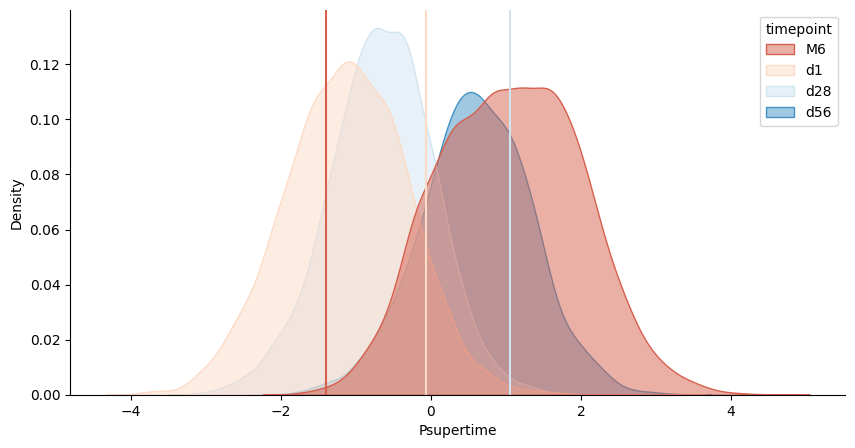

In [73]:
fig = psuper_p_bcells.plot_labels_over_psupertime(cohort_p_bcells, "timepoint")
fig.savefig("cohort_p_bcells_labels_over_psupertime_v1.png")